In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from torchtext import datasets
import jieba
from torchtext.vocab import Vectors
import torch.nn.functional as F

In [4]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,text):
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        #cat = torch.cat(pooled, dim = 1)
        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)
    
def tokenizer(text):
    return [t.strip() for t in jieba.cut(text)]

In [5]:
TEXT = data.Field(sequential=True,tokenize=tokenizer)
LABEL = data.Field(sequential=False, use_vocab=False)
train,test = data.TabularDataset.splits(
        path='./', train='virus_train.csv', test='virus_test.csv' ,format='csv',skip_header=True,
        fields=[('id',None),('content',TEXT),('label',LABEL)])
vectors = Vectors(name='./weibo.vector.txt')
TEXT.build_vocab(train,vectors=vectors)

BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, test_iterator = data.BucketIterator.splits(
    (train, test), 
    batch_size = BATCH_SIZE,
    sort = False,
    device = device)

In [71]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [1,3,5]
OUTPUT_DIM = 6
DROPOUT = 0.5

model = CNNModel(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT).to(device)

In [72]:
model.embedding.weight.data.copy_(TEXT.vocab.vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0907,  0.0099,  0.2848,  ..., -0.0727, -0.1706, -0.1358],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [73]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)

In [74]:
N_EPOCHES = 10
TOTAL = len(train_iterator.dataset)
train_epoch_loss = []
test_epoch_loss = []
for i in range(N_EPOCHES):
    train_accur = 0
    epoch_loss = 0.0
    test_loss = 0.0
    for batch in train_iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.content)
        
        loss = criterion(predictions, batch.label)
                
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        train_accur += predictions.argmax(dim = 1).eq(batch.label).sum().item()
    
    print("epoch {}, loss : {}, accur : {}".format(i + 1, epoch_loss, train_accur / TOTAL))
    train_epoch_loss.append(epoch_loss)
    
    for batch in test_iterator:
        predictions = model(batch.content)

        loss = criterion(predictions, batch.label)

        test_loss += loss.item()
    test_epoch_loss.append(test_loss)

epoch 1, loss : 283.3010131716728, accur : 0.6165465953985592
epoch 2, loss : 240.86555108428, accur : 0.6745293980943528
epoch 3, loss : 194.4969670921564, accur : 0.7514524750174297
epoch 4, loss : 146.10253557562828, accur : 0.8275621659307459
epoch 5, loss : 105.48146730661392, accur : 0.8733441784801301
epoch 6, loss : 78.49531762301922, accur : 0.907273994887288
epoch 7, loss : 60.39220277965069, accur : 0.9302811991633744
epoch 8, loss : 48.209789864718914, accur : 0.9455031373460376
epoch 9, loss : 42.27574396878481, accur : 0.9546827794561934
epoch 10, loss : 34.9427613504231, accur : 0.958284917499419


In [82]:
model.eval()
test_loss = 0.0
test_accur = 0
test_len = len(test_iterator.dataset)
y_true = []
y_pred = []
for batch in test_iterator:
    predictions = model(batch.content)
    
    loss = criterion(predictions, batch.label)
    
    test_loss += loss.item()
    
    test_accur += predictions.argmax(dim = 1).eq(batch.label).sum().item()
    
    y_true.extend(batch.label.detach().cpu().numpy())
    y_pred.extend(predictions.argmax(dim = 1).detach().cpu().numpy())
print("test loss: {}, test accur : {}".format(test_loss, test_accur / test_len))

test loss: 90.34558898210526, test accur : 0.6545


In [68]:
from sklearn.metrics import precision_score,recall_score,f1_score

In [57]:
import numpy as np

In [58]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

In [70]:
precision_score(y_true = y_true, y_pred = y_pred,average='macro')

0.5278168974307018

In [67]:
recall_score(y_true,y_pred,average='macro')

0.5010372346048008

In [69]:
f1_score(y_true=y_true,y_pred=y_pred,average='macro')

0.5109107294648714

In [75]:
from matplotlib import pyplot as plt

In [79]:
x = np.arange(1, N_EPOCHES + 1)

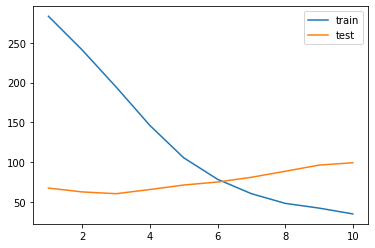

In [81]:
plt.plot(x,train_epoch_loss,label='train')
plt.plot(x,test_epoch_loss, label = 'test')
plt.legend()
plt.show()